In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [45]:
fig_width = 14

In [6]:
dirnames = ["../checkpoints/b001/",
            "../checkpoints/s170/20210522-1702/"]

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
q_values = vh.load_and_convert_q_values(dirnames)

No Q-value list found for ../checkpoints/b001/.


In [9]:
vh.get_arguments_overview(dirnames)

,b001,s170
algorithm,baseline_rule-based,ddqn
lr,0.01,0.08
discount_factor,0.9,0.7
batch_size,128,256
lambda_rwd_mstpc,0.1,0.15
lambda_rwd_energy,5e-06,2.5e-06
log_rwd_energy_and_kWh,0,NaN
reward_offset,0.0,0.05
stp_reward_step_offset,0.0,1.0
use_cuda,0,1


In [10]:
vh.get_runtime_overview_df(alldfs, dirnames)

,b001,s170
Number of training episodes,1.0,105790.000000
Runtime in s,0.0,963403.880363
Runtime in h,0.0,267.612189
Mean episode runtime in s,0.0,9.106758
Mean episode runtime during eval. episode in s,0.0,9.333661
Mean episode runtime after eval. episode in s,NaN,8.968649
Mean episode runtime in no eval. episode in s,NaN,9.105331


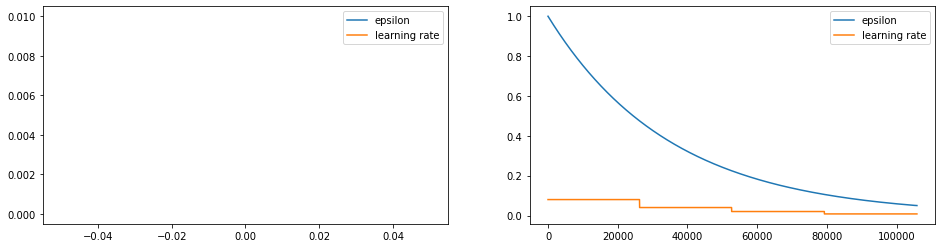

In [11]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

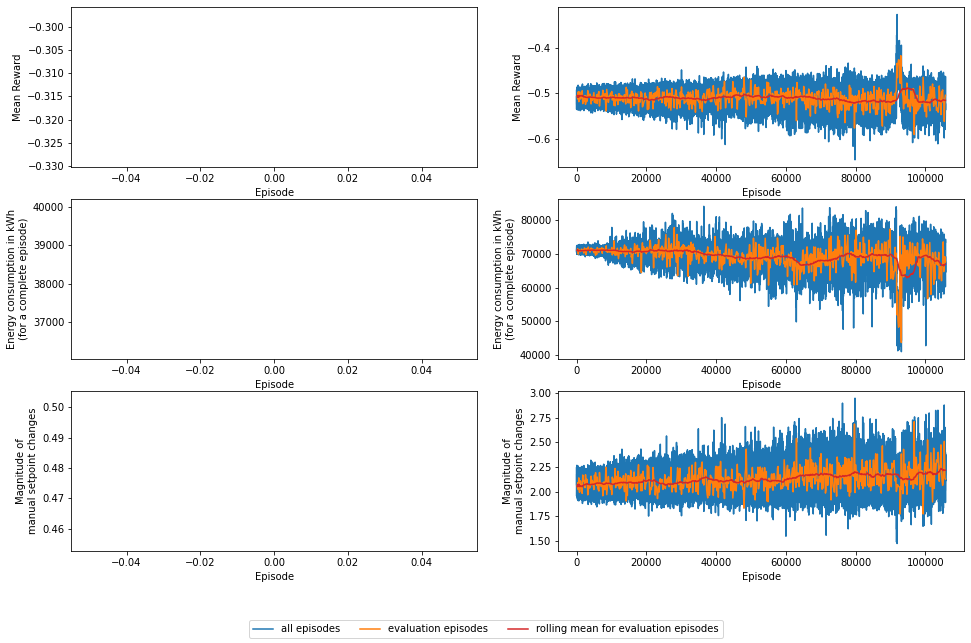

In [12]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

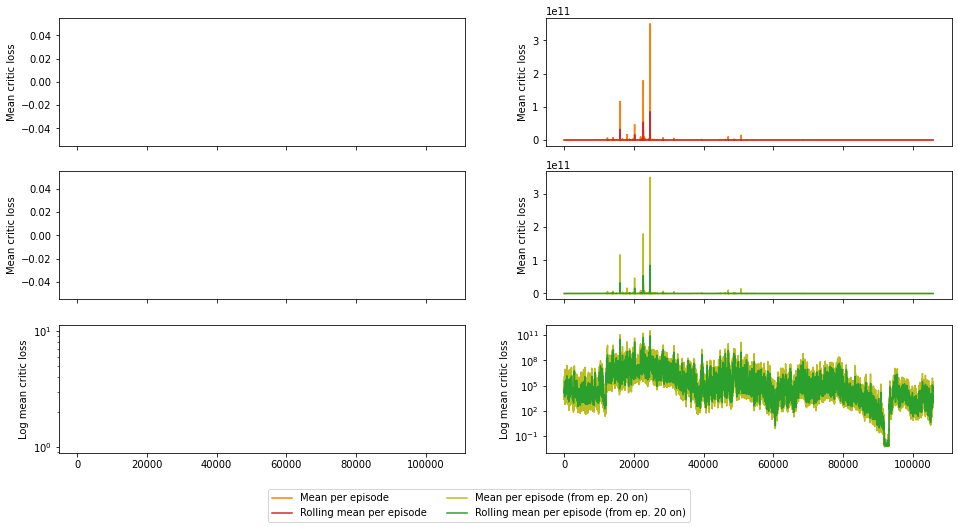

In [13]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

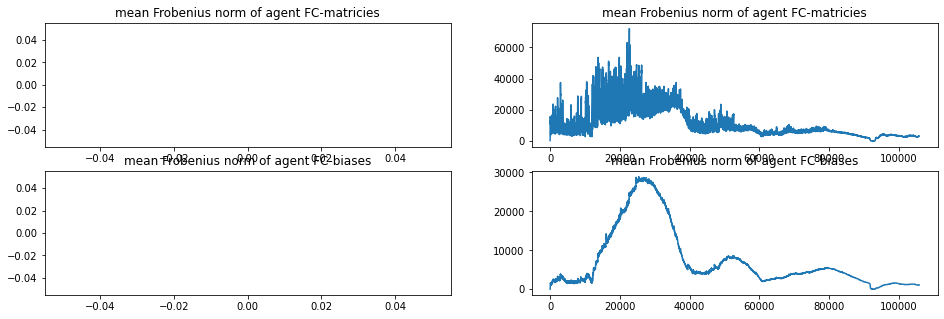

In [14]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [15]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:      0
Last available evaluation episode for dfs1: 105759


<h3>Details for one week</h3>

In [16]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [17]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [18]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode     0: Energy consumption:   38118.41 kWh; Numer of setpoint changes: 344.43972940869935
For episode 105759: Energy consumption:   73514.42 kWh; Numer of setpoint changes: 1525.133210795767

Mean values for episode ...
...     0: Reward: -0.31298 kWh; Setpoint change magnit.:  0.47905; Energy cons.: 53015.87025
... 105759: Reward: -0.52379 kWh; Setpoint change magnit.:  2.12119; Energy cons.: 102245.36607


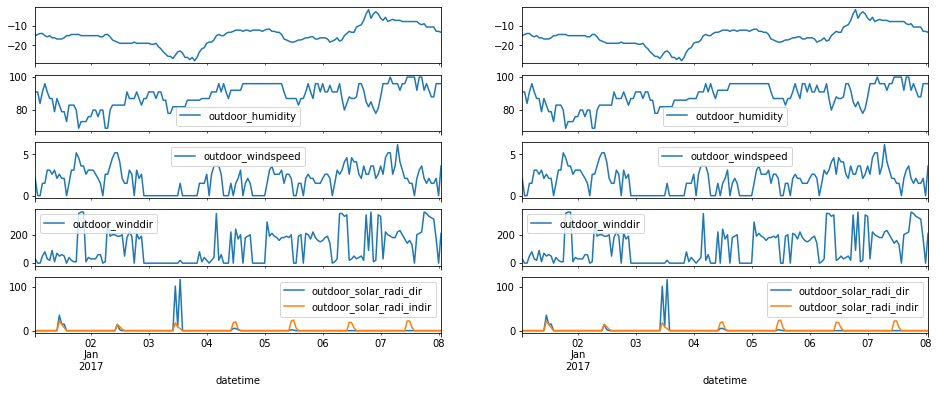

In [19]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

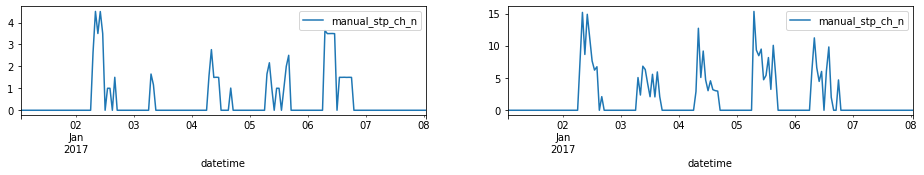

In [20]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

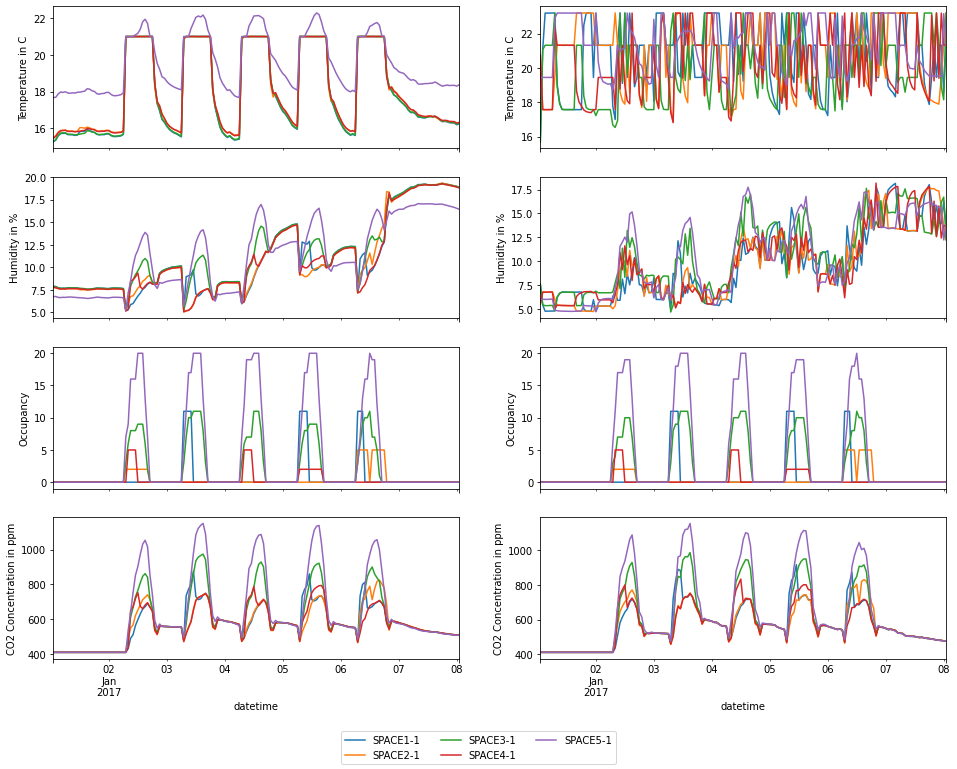

In [21]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [22]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: {'all': 0} 



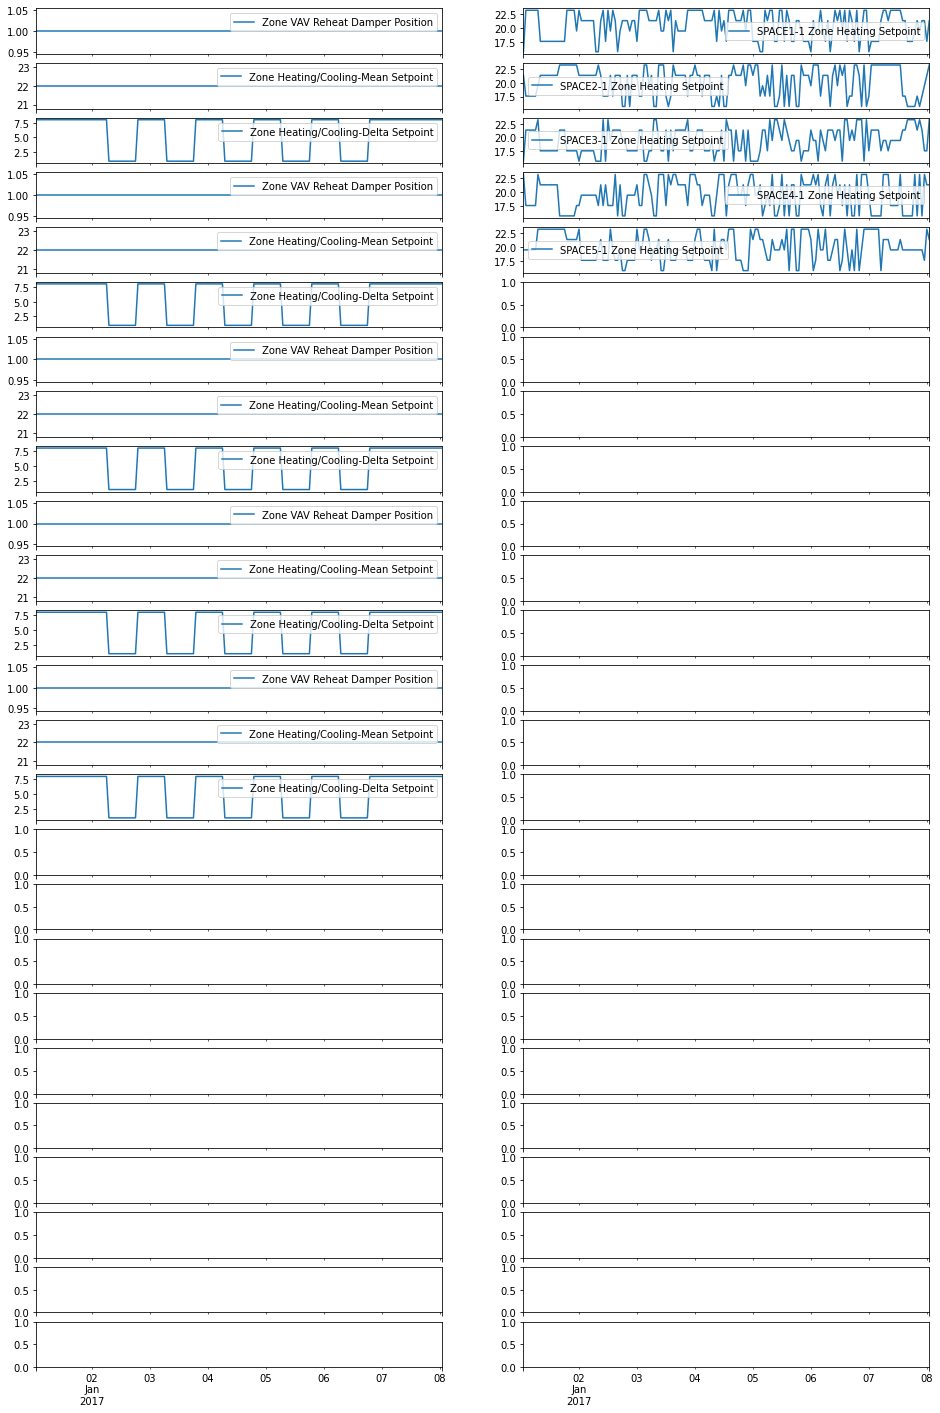

In [23]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

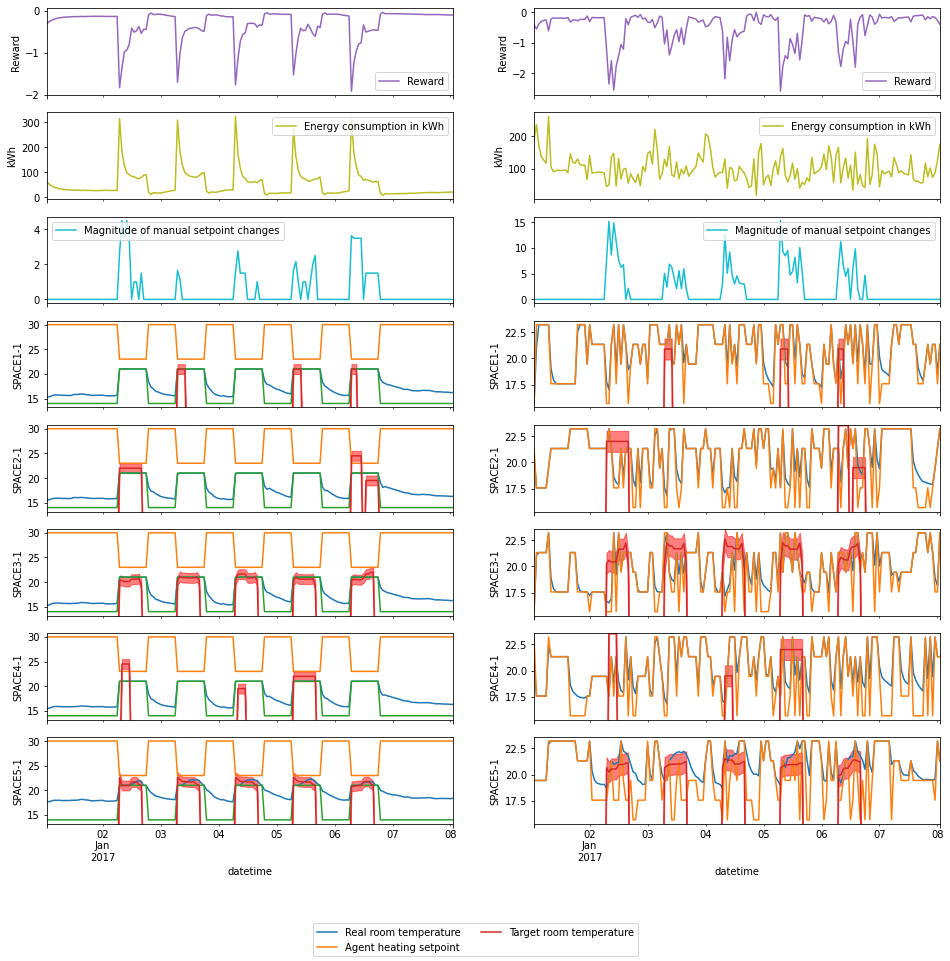

In [24]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [25]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [26]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

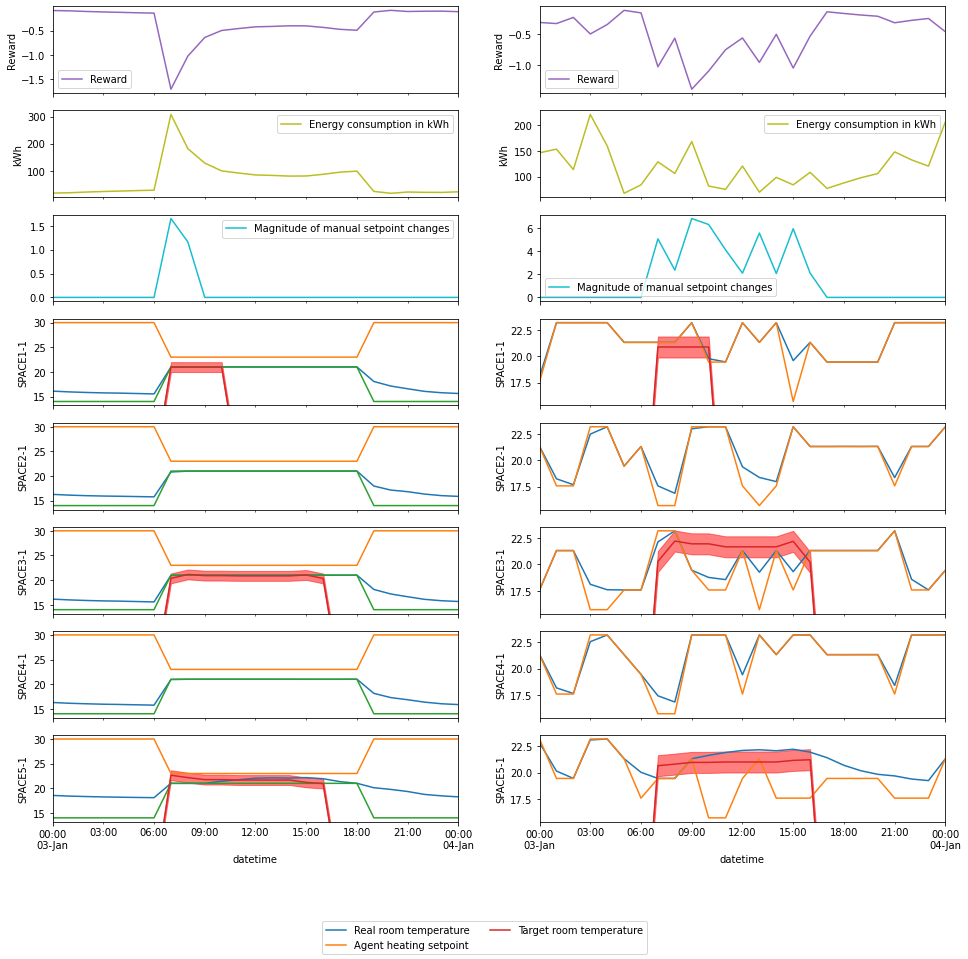

In [27]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a complete month</h3>

In [28]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [29]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

For plot number 1, mean energy consumption =  52110.2 Wh, mean reward = -0.3067
For plot number 2, mean energy consumption = 102352.6 Wh, mean reward = -0.5135


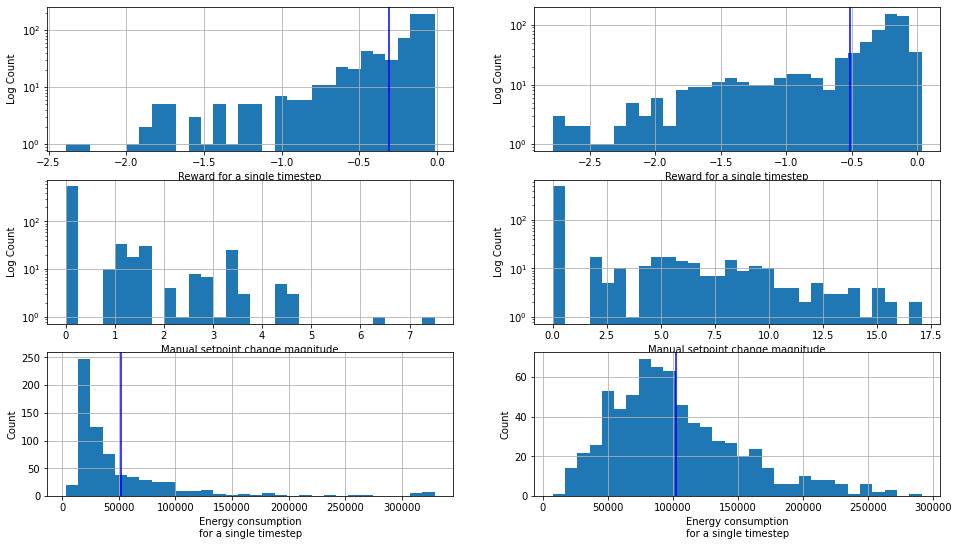

In [30]:
vh.plot_stpch_and_econs_distrib(subdfs, fig_width)

IndexError: index 5 is out of bounds for axis 0 with size 5

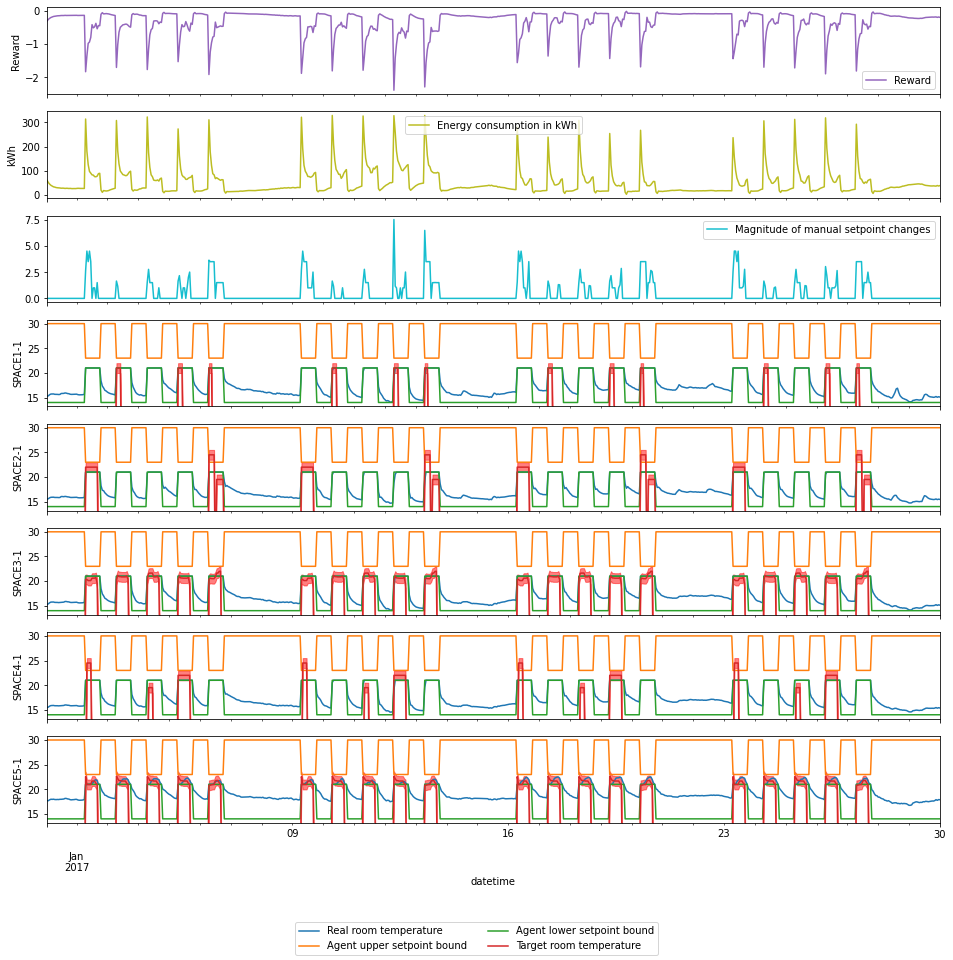

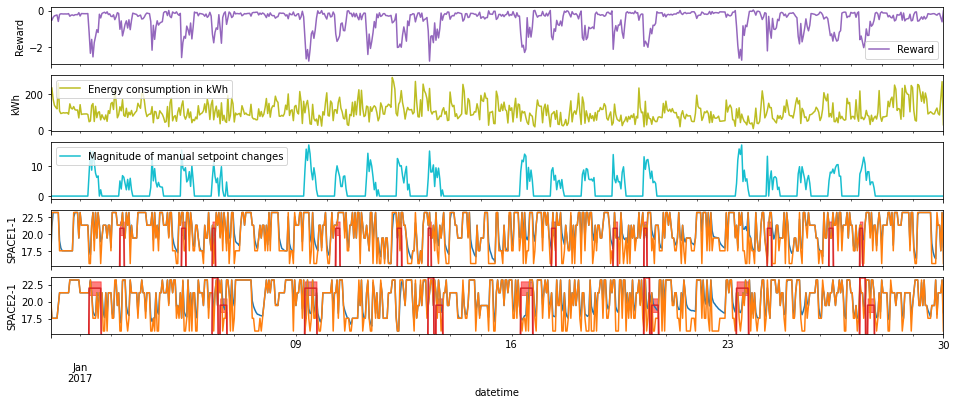

In [31]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

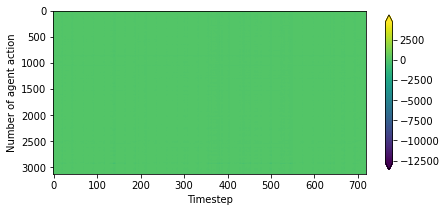

In [91]:
p, ax = vh.plot_q_values(q_values, fig_width=7, y_label="Number of agent action", x_label="Timestep")

In [77]:
for a in ax:
    for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                 a.get_xticklabels() + a.get_yticklabels()):
        item.set_fontsize(13)

In [79]:
p.tight_layout()

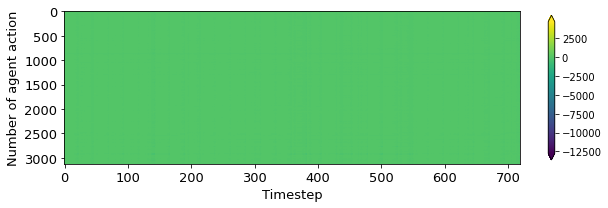

In [80]:
p

In [81]:
p.savefig("saved_plots/SingleBigAgent_QValues_s170.eps")

In [58]:
qmat = q_values["1: s170"][0]
print("Minimal computed q-value:", qmat.min())
print("Maximal computed q-value:", qmat.max())
print("Mean computed q-value:", qmat.mean())

Minimal computed q-value: -12753.178
Maximal computed q-value: 4706.355
Mean computed q-value: 9.816642


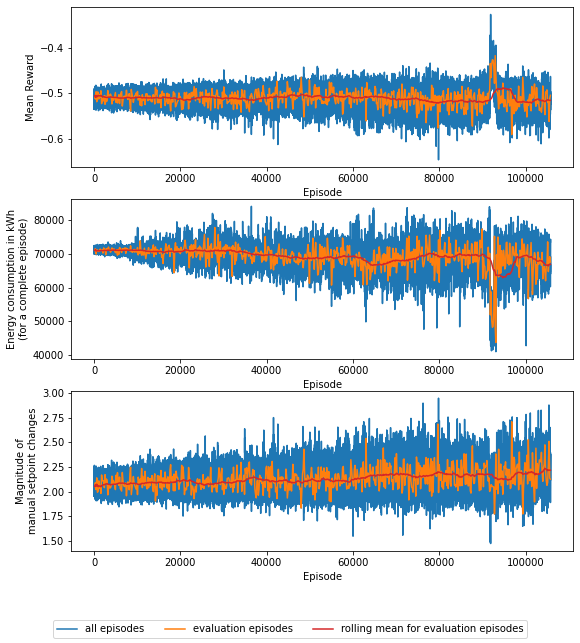

In [82]:
p, ax = vh.complete_plot_reward_stpc_econs([alldfs[1]], fig_width=9)
p.show()

In [83]:
for elems in ax:
    print(elems)
    a = elems[0]
    for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                 a.get_xticklabels() + a.get_yticklabels()):
        item.set_fontsize(13)

[<AxesSubplot:xlabel='Episode', ylabel='Mean Reward'>]
[<AxesSubplot:xlabel='Episode', ylabel='Energy consumption in kWh\n(for a complete episode)'>]
[<AxesSubplot:xlabel='Episode', ylabel='Magnitude of\nmanual setpoint changes'>]


In [85]:
p.tight_layout()

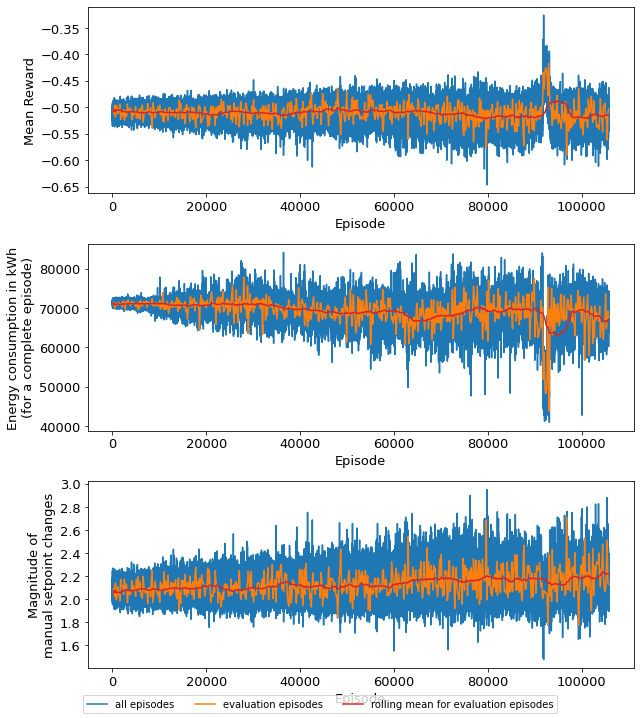

In [86]:
p

In [89]:
p.savefig("saved_plots/SingleBigAgent_Reward_s170.png")